In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import topk
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models, utils
from torchvision.utils import make_grid
from torch.autograd import Variable

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
%matplotlib inline

import time

In [2]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200,200)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Resize((200,200)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [3]:
train_data = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset',transform=train_transform)
test_data = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/dataset',transform=test_transform)

In [4]:
np.random.seed(100)
class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1)
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]

#balanced sampling (against the classes) + taking only the train_idx
train_sampler = SubsetRandomSampler(train_idx) 
test_sampler = SubsetRandomSampler(test_idx)

In [5]:
print(len(train_idx))
len(test_idx)

3094


773

In [6]:
batch_size = 100
workers = 0

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, sampler=test_sampler, num_workers=workers)

In [7]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        #(((200-2)/2) - 2)/2 = 48.5; zaokrąglone w dół
        self.fc1 = nn.Linear(48*48*12, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X)) # rectified linear unit - activation function
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 48*48*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1) # converting logits to odds

In [8]:
CNNmodel = ConvolutionalNetwork()

In [9]:
#ładowanie wag
CNNmodel.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/siec_od_0_pierwsza.pt'))

<All keys matched successfully>

In [10]:
CNNmodel.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=27648, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

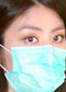

In [11]:
from PIL import Image
image = Image.open('/content/drive/MyDrive/Colab Notebooks/dataset/with_mask/0_0_0 copy 10.jpg')
image

In [12]:
image_tensor = test_transform(image)
image_tensor = image_tensor.unsqueeze(0)

In [13]:
with torch.no_grad():
    output = CNNmodel(image_tensor)
    print(output)
pos = output[0].argmax()
print(pos)
class_names[pos]

tensor([[-9.0953e-05, -9.3053e+00]])
tensor(0)


'with_mask'

In [14]:
 class_list =[]
 for i, label in test_data:
  image_tensor = i.unsqueeze(0) 
  with torch.no_grad():
    output = CNNmodel(image_tensor)
  pos = output[0].argmax()
  class_list.append([class_names[pos], label])

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [21]:
df = pd.DataFrame(class_list, columns=['Real', 'Predicted'])

In [25]:
df.loc[df.Real == 'with_mask', "Real"] = 0
df.loc[df.Real == 'without_mask', "Real"] = 1

In [26]:
df

,Real,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3862,1,1
3863,1,1
3864,1,1
3865,0,1


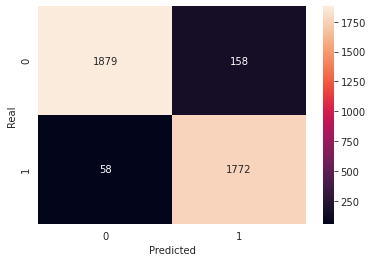

In [27]:
conf_matr =pd.crosstab(df["Real"], df["Predicted"], rownames=["Real"], colnames=["Predicted"])
sn.set_style('darkgrid')
sn.heatmap(conf_matr, annot=True, fmt='g')
plt.show()

In [28]:
real = df["Real"].values.tolist()
predicted = df["Predicted"].values.tolist()

In [29]:
TPR = (conf_matr[0][0])/(conf_matr[0][0] + conf_matr[1][0])
TNR = (conf_matr[1][1])/(conf_matr[1][1] + conf_matr[0][1])
FPR = (conf_matr[0][1])/(conf_matr[0][1] + conf_matr[1][1])
FNR = (conf_matr[1][0])/(conf_matr[1][0] + conf_matr[0][0])
ACC = (conf_matr[0][0] + conf_matr[1][1])/(conf_matr[1][0] + conf_matr[1][1]+conf_matr[0][0] + conf_matr[0][1])

In [30]:
stats = pd.DataFrame([["TPR",TPR],["TNR",TNR],["FPR",FPR],["FNR",FNR],["ACC",ACC]], columns=["Stats","Value"])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


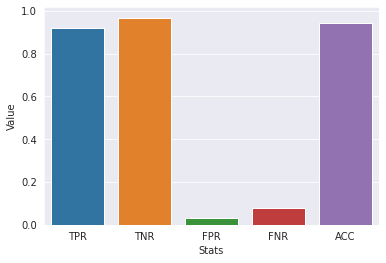

In [31]:
sn.barplot(stats["Stats"], stats["Value"],)
plt.show()